In [ ]:
import matplotlib.pyplot as plt
import torch

/Users/corneliusschroeder/anaconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
# generate some dummy data for testing


def generate_dummy_data(n_samples: int, n_features=2, offset=0):
    x = torch.randn(n_samples, n_features) + offset
    return x


x = generate_dummy_data(1000)
x_obs = generate_dummy_data(1, offset=2)

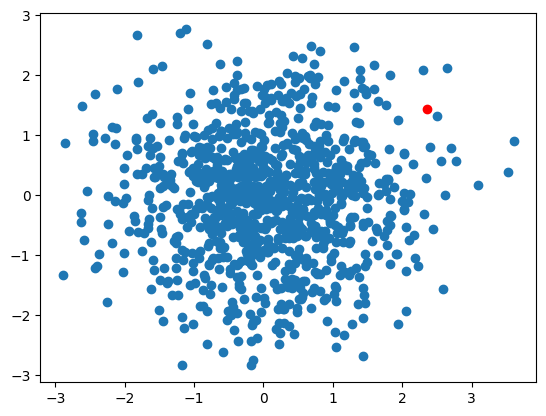

In [57]:
plt.plot(x[:, 0], x[:, 1], "o")
plt.plot(x_obs[:, 0], x_obs[:, 1], "o", color="red")

In [58]:
# code for MMD from:
# https://github.com/mackelab/labproject/blob/main/labproject/metrics/MMD_torch.py

# NOTE: all tensors should be of shape (n_samples, n_features)


def rbf_kernel(x, y, bandwidth):
    dist = torch.cdist(x, y)
    return torch.exp(-(dist**2) / (2.0 * bandwidth**2))


def median_heuristic(x, y):
    return torch.median(torch.cdist(x, y))


def compute_rbf_mmd(x, y, bandwidth=1.0, mode="biased"):
    x_kernel = rbf_kernel(x, x, bandwidth)
    y_kernel = rbf_kernel(y, y, bandwidth)
    xy_kernel = rbf_kernel(x, y, bandwidth)
    if mode == "biased":
        mmd = torch.mean(x_kernel) + torch.mean(y_kernel) - 2 * torch.mean(xy_kernel)
    elif mode == "unbiased":
        mmd = (
            torch.sum(x_kernel) / (x_kernel.shape[0] * (x_kernel.shape[0] - 1))
            + torch.sum(y_kernel) / (y_kernel.shape[0] * (y_kernel.shape[0] - 1))
            - 2 * torch.mean(xy_kernel)
        )
    else:
        raise ValueError("mode should be either biased or unbiased")
    return mmd


def compute_rbf_mmd_median_heuristic(x, y, mode="biased"):
    # https://arxiv.org/pdf/1707.07269.pdf
    bandwidth = median_heuristic(x, y)
    return compute_rbf_mmd(x, y, bandwidth, mode)


def compute_rbf_mmd_auto(x, y, bandwidth=1.0):
    dim = x.shape[1]
    x_kernel = rbf_kernel(x, x, dim * bandwidth)
    y_kernel = rbf_kernel(y, y, dim * bandwidth)
    xy_kernel = rbf_kernel(x, y, dim * bandwidth)
    mmd = torch.mean(x_kernel) + torch.mean(y_kernel) - 2 * torch.mean(xy_kernel)
    return mmd

In [ ]:
bandwidth = median_heuristic(x, x_obs)
print(compute_rbf_mmd(x, x_obs, bandwidth))
print(compute_rbf_mmd(x, x_obs, bandwidth, mode="unbiased"))

tensor(0.0018)
tensor(0.0029)


In [ ]:
def calculate_baseline_mmd(x_obs, y, n_samples=1000, mode="biased"):
    # calculate the MMD between two sets of synthetic data
    mmds = torch.zeros(n_samples)
    n_obs = x_obs.shape[0]
    if n_obs > y.shape[0]:
        raise ValueError(
            "n of observed samples should be less than n of synthetic samples"
        )
    for i in range(n_samples):
        idx = torch.randperm(y.shape[0])
        mmds[i] = compute_rbf_mmd_median_heuristic(
            y[idx[:n_obs]], y[idx[n_obs:]], mode=mode
        )
    return mmds

In [ ]:
mmds_baseline = calculate_baseline_mmd(x_obs, x, n_samples=1000, mode="biased")
mmd = compute_rbf_mmd_median_heuristic(x_obs, x, mode="biased")

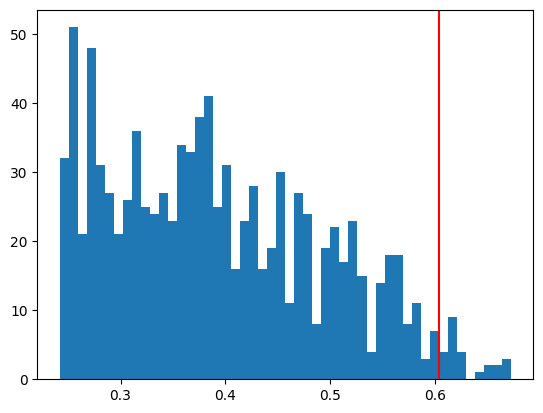

In [ ]:
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd, color="red")
plt.show()